In [2]:
import pandas as pd
import numpy as np
import os

In [8]:
# this cell runs this pipeline and saves the data for all chr.
# for individual analysis, see each cells below
# Define a function to summarize peaks per gene
def summarize_peaks(df):
    # For each gene, find peak closest to gene_start (TSS)
    df['tss_dist'] = abs(df['peak_start'] - df['gene_start'])
    tss_peak = df.loc[df.groupby('gene_name')['tss_dist'].idxmin()][['gene_name', 'signalValue']].rename(columns={'signalValue': 'tss_signal'})
    avg_peak = df.groupby('gene_name')['signalValue'].mean().reset_index().rename(columns={'signalValue': 'avg_signal'})
    return pd.merge(tss_peak, avg_peak, on='gene_name', how='outer')
            
def extract_inf_unf_diff_expr_acc(file_path):
    for chr_folder_name in os.listdir(file_path):
        chr_path = os.path.join(file_path, chr_folder_name)
        if not os.path.isdir(chr_path) or not chr_folder_name.startswith('chr'):
            continue
        # Load gene expression CSVs
        expr_12 = pd.read_csv(f'{file_path}{chr_folder_name}/mapped_vacv12_vs_untr12_DESEQ_norm_{chr_folder_name}.csv', sep=',')
        expr_18 = pd.read_csv(f'{file_path}{chr_folder_name}/mapped_vacv18_vs_untr18_DESEQ_norm_{chr_folder_name}.csv', sep=',')
        expr_24 = pd.read_csv(f'{file_path}{chr_folder_name}/mapped_vacv24_vs_untr24_DESEQ_norm_{chr_folder_name}.csv', sep=',')
        # Select gene_name and log2FoldChange, rename columns for merging
        expr_12 = expr_12[['gene_name', 'log2FoldChange']].rename(columns={'log2FoldChange': 'log2FC_12h'})
        expr_18 = expr_18[['gene_name', 'log2FoldChange']].rename(columns={'log2FoldChange': 'log2FC_18h'})
        expr_24 = expr_24[['gene_name', 'log2FoldChange']].rename(columns={'log2FoldChange': 'log2FC_24h'})
        
        # Merge all genes
        expr_merge = pd.merge(expr_12, expr_18, on='gene_name', how='outer')
        expr_merge = pd.merge(expr_merge, expr_24, on='gene_name', how='outer')
        
        # Load accessibility files
        acc_files = {
            'untr_12h': f'{file_path}{chr_folder_name}/12hrs/untr/structure_12hrs_untr_gene_peak_mapped.csv',
            'vacv_12h': f'{file_path}{chr_folder_name}/12hrs/vacv/structure_12hrs_vacv_gene_peak_mapped.csv',
            'untr_18h': f'{file_path}{chr_folder_name}/18hrs/untr/structure_18hrs_untr_gene_peak_mapped.csv',
            'vacv_18h': f'{file_path}{chr_folder_name}/18hrs/vacv/structure_18hrs_vacv_gene_peak_mapped.csv',
            'untr_24h': f'{file_path}{chr_folder_name}/24hrs/untr/structure_24hrs_untr_gene_peak_mapped.csv',
            'vacv_24h': f'{file_path}{chr_folder_name}/24hrs/vacv/structure_24hrs_vacv_gene_peak_mapped.csv'
        }
        
        acc_summary = None
        
        for label, file in acc_files.items():
            df = pd.read_csv(file)
            summ = summarize_peaks(df)
            # Rename columns for this time/condition
            summ = summ.rename(columns={
                'tss_signal': f'acc_{label}_tss',
                'avg_signal': f'acc_{label}_avg'
            })
            # Merge with master table
            if acc_summary is None:
                acc_summary = summ
            else:
                acc_summary = pd.merge(acc_summary, summ, on='gene_name', how='outer')

        #step 3: Merge expression and accessibility tables on gene_name, keeping only shared genes
        expr_acc_merged = pd.merge(expr_merge, acc_summary, on='gene_name', how='inner')

        # Expression deltas already in the data
        expr_acc_merged['expr_delta_12h'] = expr_acc_merged['log2FC_12h']
        expr_acc_merged['expr_delta_18h'] = expr_acc_merged['log2FC_18h']
        expr_acc_merged['expr_delta_24h'] = expr_acc_merged['log2FC_24h']
        
        # Accessibility deltas for UNTR (TSS and avg)
        expr_acc_merged['acc_delta_12h_tss'] = expr_acc_merged['acc_vacv_12h_tss'] - expr_acc_merged['acc_untr_12h_tss']
        expr_acc_merged['acc_delta_18h_tss'] = expr_acc_merged['acc_vacv_18h_tss'] - expr_acc_merged['acc_untr_18h_tss']
        expr_acc_merged['acc_delta_24h_tss'] = expr_acc_merged['acc_vacv_24h_tss'] - expr_acc_merged['acc_untr_24h_tss']
        
        # expr_acc_merged['acc_delta_12h_avg'] = expr_acc_merged['acc_vacv_12h_avg'] - expr_acc_merged['acc_untr_12h_avg']
        # expr_acc_merged['acc_delta_18h_avg'] = expr_acc_merged['acc_vacv_18h_avg'] - expr_acc_merged['acc_untr_18h_avg']
        # expr_acc_merged['acc_delta_24h_avg'] = expr_acc_merged['acc_vacv_24h_avg'] - expr_acc_merged['acc_untr_24h_avg']

        #save the data
        # Select only gene_name and delta columns
        delta_cols = ['gene_name'] + [col for col in expr_acc_merged.columns if 'delta' in col]
        expr_acc_merged[delta_cols].to_csv(f"{file_path}{chr_folder_name}/{chr_folder_name}_expr_acc_features.csv", index=False)

        print(f"{chr_folder_name} data saved")

file_path = 'data/green_monkey/all_structure_files/'
extract_inf_unf_diff_expr_acc(file_path)


chr23 data saved
chr12 data saved
chr15 data saved
chr14 data saved
chr13 data saved
chr25 data saved
chr22 data saved
chr4 data saved
chr3 data saved
chr2 data saved
chr5 data saved
chr18 data saved
chr27 data saved
chr20 data saved
chr29 data saved
chr16 data saved
chr10 data saved
chr28 data saved
chr21 data saved
chr19 data saved
chr26 data saved
chr7 data saved
chr6 data saved
chr1 data saved


In [2]:
# step 1 : load and merge gene expression data into a single df 
# log2FoldChange attribute 

# Load gene expression CSVs
expr_12 = pd.read_csv('data/green_monkey/all_structure_files/chr1/mapped_vacv12_vs_untr12_DESEQ_norm_chr1.csv', sep=',')
expr_18 = pd.read_csv('data/green_monkey/all_structure_files/chr1/mapped_vacv18_vs_untr18_DESEQ_norm_chr1.csv', sep=',')
expr_24 = pd.read_csv('data/green_monkey/all_structure_files/chr1/mapped_vacv24_vs_untr24_DESEQ_norm_chr1.csv', sep=',')

# Select gene_name and log2FoldChange, rename columns for merging
expr_12 = expr_12[['gene_name', 'log2FoldChange']].rename(columns={'log2FoldChange': 'log2FC_12h'})
expr_18 = expr_18[['gene_name', 'log2FoldChange']].rename(columns={'log2FoldChange': 'log2FC_18h'})
expr_24 = expr_24[['gene_name', 'log2FoldChange']].rename(columns={'log2FoldChange': 'log2FC_24h'})

# Merge all genes
expr_merge = pd.merge(expr_12, expr_18, on='gene_name', how='outer')
expr_merge = pd.merge(expr_merge, expr_24, on='gene_name', how='outer')

# Show result
expr_merge.head()


,gene_name,log2FC_12h,log2FC_18h,log2FC_24h
0,SCGB1C1,NaN,NaN,NaN
1,ODF3,NaN,NaN,NaN
2,BET1L,-0.315039,-0.368512,-0.155558
3,RIC8A,-0.295795,-0.221668,-0.362167
4,SIRT3,0.552196,-0.984313,0.300940


In [3]:
# step 2 - load acc data - summarize them by avg peaks and TSS-based (the one closest to gene start)

# Define a function to summarize peaks per gene
def summarize_peaks(df):
    # For each gene, find peak closest to gene_start (TSS)
    df['tss_dist'] = abs(df['peak_start'] - df['gene_start'])
    tss_peak = df.loc[df.groupby('gene_name')['tss_dist'].idxmin()][['gene_name', 'signalValue']].rename(columns={'signalValue': 'tss_signal'})
    avg_peak = df.groupby('gene_name')['signalValue'].mean().reset_index().rename(columns={'signalValue': 'avg_signal'})
    return pd.merge(tss_peak, avg_peak, on='gene_name', how='outer')

# Load accessibility files
acc_files = {
    'untr_12h': 'data/green_monkey/all_structure_files/chr1/12hrs/untr/structure_12hrs_untr_gene_peak_mapped.csv',
    'vacv_12h': 'data/green_monkey/all_structure_files/chr1/12hrs/vacv/structure_12hrs_vacv_gene_peak_mapped.csv',
    'untr_18h': 'data/green_monkey/all_structure_files/chr1/18hrs/untr/structure_18hrs_untr_gene_peak_mapped.csv',
    'vacv_18h': 'data/green_monkey/all_structure_files/chr1/18hrs/vacv/structure_18hrs_vacv_gene_peak_mapped.csv',
    'untr_24h': 'data/green_monkey/all_structure_files/chr1/24hrs/untr/structure_24hrs_untr_gene_peak_mapped.csv',
    'vacv_24h': 'data/green_monkey/all_structure_files/chr1/24hrs/vacv/structure_24hrs_vacv_gene_peak_mapped.csv'
}

acc_summary = None

for label, file in acc_files.items():
    df = pd.read_csv(file)
    summ = summarize_peaks(df)
    # Rename columns for this time/condition
    summ = summ.rename(columns={
        'tss_signal': f'acc_{label}_tss',
        'avg_signal': f'acc_{label}_avg'
    })
    # Merge with master table
    if acc_summary is None:
        acc_summary = summ
    else:
        acc_summary = pd.merge(acc_summary, summ, on='gene_name', how='outer')

# Show result
acc_summary.head()


,gene_name,acc_untr_12h_tss,acc_untr_12h_avg,acc_vacv_12h_tss,acc_vacv_12h_avg,acc_untr_18h_tss,acc_untr_18h_avg,acc_vacv_18h_tss,acc_vacv_18h_avg,acc_untr_24h_tss,acc_untr_24h_avg,acc_vacv_24h_tss,acc_vacv_24h_avg
0,AAMDC,22.13390,16.119228,16.17840,15.953723,16.31210,14.283873,12.51860,14.423562,10.57260,9.771665,5.64888,10.087290
1,AASDHPPT,4.81171,29.511803,18.87490,22.470100,4.22906,16.010015,17.41710,18.505700,4.80575,11.613895,6.45586,8.069825
2,ABCC8,4.33054,9.113937,6.06692,8.403798,3.92698,6.887328,4.35428,5.517074,5.76690,6.477310,3.22793,4.774648
3,ABCG4,5.77405,4.210245,10.11150,6.235435,8.45812,4.503674,5.98714,5.034641,4.80575,4.745675,4.84190,4.150197
4,ABTB2,7.21756,17.285604,7.41512,12.759780,27.48890,11.024326,5.44286,8.654141,5.28632,9.649558,7.26285,6.215949


In [4]:
#step 3: Merge expression and accessibility tables on gene_name, keeping only shared genes
expr_acc_merged = pd.merge(expr_merge, acc_summary, on='gene_name', how='inner')

# Show the result
expr_acc_merged.head()


,gene_name,log2FC_12h,log2FC_18h,log2FC_24h,acc_untr_12h_tss,acc_untr_12h_avg,acc_vacv_12h_tss,acc_vacv_12h_avg,acc_untr_18h_tss,acc_untr_18h_avg,acc_vacv_18h_tss,acc_vacv_18h_avg,acc_untr_24h_tss,acc_untr_24h_avg,acc_vacv_24h_tss,acc_vacv_24h_avg
0,SCGB1C1,NaN,NaN,NaN,5.77405,8.179925,12.13380,6.516307,3.02076,5.092134,5.44286,5.715000,4.80575,4.325175,NaN,NaN
1,ODF3,NaN,NaN,NaN,5.77405,4.210245,5.39281,4.718710,3.92698,4.805749,5.44286,5.007430,5.76690,4.613518,4.84190,5.110893
2,BET1L,-0.315039,-0.368512,-0.155558,18.76570,23.817952,6.06692,16.777641,3.32283,13.126565,5.44286,10.885704,3.84460,13.335952,12.10470,12.104700
3,RIC8A,-0.295795,-0.221668,-0.362167,18.76570,19.728002,4.04461,16.552940,4.22906,15.305173,5.44286,11.792845,26.91220,16.659928,4.03491,4.438405
4,SIRT3,0.552196,-0.984313,0.300940,3.84937,15.466200,4.71871,12.673082,3.62491,9.389523,3.26571,6.259278,4.32517,10.933093,3.22793,4.034912


In [5]:
# step 4 compute differences ==> log2FC_18_vacv - log2FC_18_untr
# acc_VACV_12hr - acc_UNTR_12hr

# Expression deltas already in the data
expr_acc_merged['expr_delta_12h'] = expr_acc_merged['log2FC_12h']
expr_acc_merged['expr_delta_18h'] = expr_acc_merged['log2FC_18h']
expr_acc_merged['expr_delta_24h'] = expr_acc_merged['log2FC_24h']

# Accessibility deltas for UNTR (TSS and avg)
expr_acc_merged['acc_delta_12h_tss'] = expr_acc_merged['acc_vacv_12h_tss'] - expr_acc_merged['acc_untr_12h_tss']
expr_acc_merged['acc_delta_18h_tss'] = expr_acc_merged['acc_vacv_18h_tss'] - expr_acc_merged['acc_untr_18h_tss']
expr_acc_merged['acc_delta_24h_tss'] = expr_acc_merged['acc_vacv_24h_tss'] - expr_acc_merged['acc_untr_24h_tss']

expr_acc_merged['acc_delta_12h_avg'] = expr_acc_merged['acc_vacv_12h_avg'] - expr_acc_merged['acc_untr_12h_avg']
expr_acc_merged['acc_delta_18h_avg'] = expr_acc_merged['acc_vacv_18h_avg'] - expr_acc_merged['acc_untr_18h_avg']
expr_acc_merged['acc_delta_24h_avg'] = expr_acc_merged['acc_vacv_24h_avg'] - expr_acc_merged['acc_untr_24h_avg']

# Show the final table
expr_acc_merged.head()


,gene_name,log2FC_12h,log2FC_18h,log2FC_24h,acc_untr_12h_tss,acc_untr_12h_avg,acc_vacv_12h_tss,acc_vacv_12h_avg,acc_untr_18h_tss,acc_untr_18h_avg,...,acc_vacv_24h_avg,expr_delta_12h,expr_delta_18h,expr_delta_24h,acc_delta_12h_tss,acc_delta_18h_tss,acc_delta_24h_tss,acc_delta_12h_avg,acc_delta_18h_avg,acc_delta_24h_avg
0,SCGB1C1,NaN,NaN,NaN,5.77405,8.179925,12.13380,6.516307,3.02076,5.092134,...,NaN,NaN,NaN,NaN,6.35975,2.42210,NaN,-1.663618,0.622866,NaN
1,ODF3,NaN,NaN,NaN,5.77405,4.210245,5.39281,4.718710,3.92698,4.805749,...,5.110893,NaN,NaN,NaN,-0.38124,1.51588,-0.92500,0.508465,0.201681,0.497375
2,BET1L,-0.315039,-0.368512,-0.155558,18.76570,23.817952,6.06692,16.777641,3.32283,13.126565,...,12.104700,-0.315039,-0.368512,-0.155558,-12.69878,2.12003,8.26010,-7.040311,-2.240861,-1.231253
3,RIC8A,-0.295795,-0.221668,-0.362167,18.76570,19.728002,4.04461,16.552940,4.22906,15.305173,...,4.438405,-0.295795,-0.221668,-0.362167,-14.72109,1.21380,-22.87729,-3.175062,-3.512328,-12.221523
4,SIRT3,0.552196,-0.984313,0.300940,3.84937,15.466200,4.71871,12.673082,3.62491,9.389523,...,4.034912,0.552196,-0.984313,0.300940,0.86934,-0.35920,-1.09724,-2.793118,-3.130246,-6.898180


In [6]:
#save the data
expr_acc_merged.to_csv("data/green_monkey/all_structure_files/chr1/chr1_expr_acc_features.csv", index=False)

In [7]:
# Step 5: compute dynamic scores (variance and range)
# Variance -- how much a gene’s feature value fluctuates over time.
# Range -- the total spread between the minimum and maximum values.

# Expression (already VACV vs UNTR)
expr_acc_merged['expr_var'] = expr_acc_merged[['expr_delta_12h', 'expr_delta_18h', 'expr_delta_24h']].var(axis=1, skipna=True)
expr_acc_merged['expr_range'] = expr_acc_merged[['expr_delta_12h', 'expr_delta_18h', 'expr_delta_24h']].max(axis=1) - \
                                expr_acc_merged[['expr_delta_12h', 'expr_delta_18h', 'expr_delta_24h']].min(axis=1)

# Accessibility (delta = VACV - UNTR at each timepoint)
expr_acc_merged['acc_tss_var'] = expr_acc_merged[['acc_delta_12h_tss', 'acc_delta_18h_tss', 'acc_delta_24h_tss']].var(axis=1, skipna=True)
expr_acc_merged['acc_tss_range'] = expr_acc_merged[['acc_delta_12h_tss', 'acc_delta_18h_tss', 'acc_delta_24h_tss']].max(axis=1) - \
                                   expr_acc_merged[['acc_delta_12h_tss', 'acc_delta_18h_tss', 'acc_delta_24h_tss']].min(axis=1)

expr_acc_merged['acc_avg_var'] = expr_acc_merged[['acc_delta_12h_avg', 'acc_delta_18h_avg', 'acc_delta_24h_avg']].var(axis=1, skipna=True)
expr_acc_merged['acc_avg_range'] = expr_acc_merged[['acc_delta_12h_avg', 'acc_delta_18h_avg', 'acc_delta_24h_avg']].max(axis=1) - \
                                   expr_acc_merged[['acc_delta_12h_avg', 'acc_delta_18h_avg', 'acc_delta_24h_avg']].min(axis=1)

# Show sample
expr_acc_merged[['gene_name', 'expr_var', 'expr_range', 'acc_tss_var', 'acc_tss_range']].head()


,gene_name,expr_var,expr_range,acc_tss_var,acc_tss_range
0,SCGB1C1,NaN,NaN,7.752544,3.93765
1,ODF3,NaN,NaN,1.642106,2.44088
2,BET1L,0.012274,0.212954,116.095373,20.95888
3,RIC8A,0.004940,0.140500,150.137489,24.09109
4,SIRT3,0.679310,1.536509,0.986908,1.96658


In [8]:
# Define your timepoints as x-values
timepoints = np.array([12, 18, 24])

def compute_slope(row, cols):
    y = row[cols].values.astype(float)
    # Handle all-NA rows
    if np.all(np.isnan(y)):
        return np.nan
    # Fit a line: degree=1, return slope
    slope, _ = np.polyfit(timepoints[~np.isnan(y)], y[~np.isnan(y)], 1)
    return slope

# Expression slope
expr_cols = ['expr_delta_12h', 'expr_delta_18h', 'expr_delta_24h']
expr_acc_merged['expr_slope'] = expr_acc_merged.apply(lambda row: compute_slope(row, expr_cols), axis=1)

# Accessibility TSS slope
acc_tss_cols = ['acc_delta_12h_tss', 'acc_delta_18h_tss', 'acc_delta_24h_tss']
expr_acc_merged['acc_tss_slope'] = expr_acc_merged.apply(lambda row: compute_slope(row, acc_tss_cols), axis=1)

# Accessibility AVG slope
acc_avg_cols = ['acc_delta_12h_avg', 'acc_delta_18h_avg', 'acc_delta_24h_avg']
expr_acc_merged['acc_avg_slope'] = expr_acc_merged.apply(lambda row: compute_slope(row, acc_avg_cols), axis=1)

# Show sample output
expr_acc_merged[['gene_name', 'expr_slope', 'acc_tss_slope', 'acc_avg_slope']].head()


/var/folders/29/w54hnxjs18q9cvq1pfzwym540000gn/T/ipykernel_13098/562871172.py:10: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(timepoints[~np.isnan(y)], y[~np.isnan(y)], 1)
/var/folders/29/w54hnxjs18q9cvq1pfzwym540000gn/T/ipykernel_13098/562871172.py:10: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(timepoints[~np.isnan(y)], y[~np.isnan(y)], 1)
/var/folders/29/w54hnxjs18q9cvq1pfzwym540000gn/T/ipykernel_13098/562871172.py:10: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(timepoints[~np.isnan(y)], y[~np.isnan(y)], 1)
/var/folders/29/w54hnxjs18q9cvq1pfzwym540000gn/T/ipykernel_13098/562871172.py:10: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(timepoints[~np.isnan(y)], y[~np.isnan(y)], 1)
/var/folders/29/w54hnxjs18q9cvq1pfzwym540000gn/T/ipykernel_13098/562871172.py:10: RankWarning: Polyfit may be poorly conditioned
  slope, _ = np.polyfit(timepoints[~np.isnan(y)], y[~np.isnan(y)], 1)
/var/

,gene_name,expr_slope,acc_tss_slope,acc_avg_slope
0,SCGB1C1,NaN,-0.656275,0.381081
1,ODF3,NaN,-0.045313,-0.000924
2,BET1L,0.013290,1.746573,0.484088
3,RIC8A,-0.005531,-0.679683,-0.753872
4,SIRT3,-0.020938,-0.163882,-0.342088


In [9]:
#save the data
expr_acc_merged.to_csv("data/green_monkey/all_structure_files/chr1/chr1_expr_acc_statistics.csv", index=False)

In [10]:
# step 6: classifiy each gene (stable if below or lower than median; else dynamic)
# Count how many genes are 'stable' or 'dynamic' in each feature
# Step 6: classify each gene
expr_threshold = expr_acc_merged['expr_var'].median()
acc_threshold = expr_acc_merged['acc_tss_var'].median()

expr_acc_merged['expr_pattern'] = expr_acc_merged['expr_var'].apply(lambda x: 'dynamic' if x > expr_threshold else 'stable')
expr_acc_merged['acc_pattern'] = expr_acc_merged['acc_tss_var'].apply(lambda x: 'dynamic' if x > acc_threshold else 'stable')

summary = expr_acc_merged[['expr_pattern', 'acc_pattern']].value_counts().reset_index(name='count')
summary.head()


,expr_pattern,acc_pattern,count
0,stable,stable,463
1,stable,dynamic,359
2,dynamic,stable,318
3,dynamic,dynamic,183


In [11]:
# Get example genes
dynamic_both = expr_acc_merged.query("expr_pattern == 'dynamic' and acc_pattern == 'dynamic'").head(5)
stable_both = expr_acc_merged.query("expr_pattern == 'stable' and acc_pattern == 'stable'").head(5)


In [12]:
dynamic_both.head()

,gene_name,log2FC_12h,log2FC_18h,log2FC_24h,acc_untr_12h_tss,acc_untr_12h_avg,acc_vacv_12h_tss,acc_vacv_12h_avg,acc_untr_18h_tss,acc_untr_18h_avg,...,expr_range,acc_tss_var,acc_tss_range,acc_avg_var,acc_avg_range,expr_slope,acc_tss_slope,acc_avg_slope,expr_pattern,acc_pattern
9,LOC103241759,-0.139961,-1.433729,-3.483682,37.53130,22.133847,27.63820,16.515503,33.83250,24.770233,...,3.343721,31.245614,10.39097,30.861005,10.666977,-0.278643,-0.865914,-0.888915,dynamic,dynamic
11,LOC103241765,0.000000,0.000000,0.957403,5.29288,4.170150,NaN,NaN,3.62491,4.732520,...,0.957403,10.757888,4.63851,6.603205,3.634062,0.079784,-0.773085,-0.605677,dynamic,dynamic
17,PTDSS2,3.122805,0.000000,2.410965,37.05010,9.142240,38.42380,8.763322,25.37440,5.360089,...,3.122805,18.071213,8.49200,0.326705,1.137016,-0.059320,-0.707667,-0.038833,dynamic,dynamic
20,LRRC56,0.344293,0.702609,1.302068,5.29288,6.561417,7.41512,7.667899,6.04151,5.824018,...,0.957775,45.443518,13.10529,2.403026,2.685008,0.079815,-0.774562,-0.223745,dynamic,dynamic
41,CD151,-0.891920,-1.935374,-2.512633,3.84937,18.567528,9.43743,16.178442,3.02076,10.621373,...,1.620713,18.107752,7.41980,10.529301,6.472767,-0.135059,-0.610004,-0.235811,dynamic,dynamic


In [13]:
stable_both.head()

,gene_name,log2FC_12h,log2FC_18h,log2FC_24h,acc_untr_12h_tss,acc_untr_12h_avg,acc_vacv_12h_tss,acc_vacv_12h_avg,acc_untr_18h_tss,acc_untr_18h_avg,...,expr_range,acc_tss_var,acc_tss_range,acc_avg_var,acc_avg_range,expr_slope,acc_tss_slope,acc_avg_slope,expr_pattern,acc_pattern
1,ODF3,NaN,NaN,NaN,5.77405,4.210245,5.39281,4.718710,3.92698,4.805749,...,NaN,1.642106,2.44088,0.030279,0.306784,NaN,-0.045313,-0.000924,stable,stable
8,IFITM5,NaN,NaN,NaN,4.33054,4.330540,5.39281,4.718710,5.13529,5.316534,...,NaN,0.174920,0.75470,0.265430,0.929837,NaN,-0.005414,0.070785,stable,stable
12,IFITM3,NaN,NaN,NaN,3.84937,3.849370,4.71871,4.718710,3.32283,3.322830,...,NaN,0.013140,0.16211,0.013140,0.162110,NaN,0.027018,0.027018,stable,stable
18,RNH1,-0.450101,-0.838127,-0.804372,5.29288,11.593931,5.39281,12.639403,6.04151,8.804946,...,0.388026,2.112690,2.79307,6.960617,5.224890,-0.029523,-0.232756,-0.435408,stable,stable
21,C1H11orf35,0.231106,0.316312,0.106876,11.54810,8.661067,12.13380,8.426265,3.02076,5.038622,...,0.209435,1.655277,2.50614,3.038554,3.482437,-0.010352,0.208845,-0.133277,stable,stable


In [14]:
def slope_pattern(slope, threshold=0.05):
    if slope > threshold:
        return 'up'
    elif slope < -threshold:
        return 'down'
    else:
        return 'flat'

expr_acc_merged['expr_trend'] = expr_acc_merged['expr_slope'].apply(slope_pattern)
expr_acc_merged['acc_tss_trend'] = expr_acc_merged['acc_tss_slope'].apply(slope_pattern)
expr_acc_merged['acc_avg_trend'] = expr_acc_merged['acc_avg_slope'].apply(slope_pattern)

# Show sample
expr_acc_merged[['gene_name', 'expr_trend', 'acc_tss_trend', 'acc_avg_trend',]].head()


,gene_name,expr_trend,acc_tss_trend,acc_avg_trend
0,SCGB1C1,flat,down,up
1,ODF3,flat,flat,flat
2,BET1L,flat,up,up
3,RIC8A,flat,down,down
4,SIRT3,flat,down,down


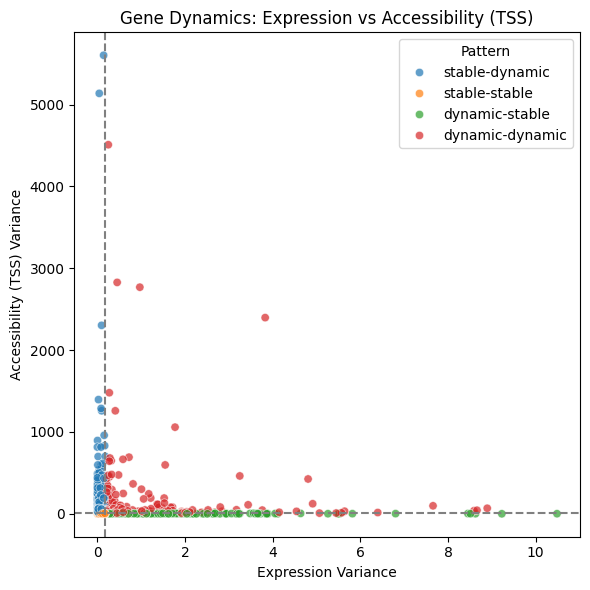

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assign a combined label
expr_acc_merged['combined_pattern'] = expr_acc_merged['expr_pattern'] + '-' + expr_acc_merged['acc_pattern']

# Plot
plt.figure(figsize=(6,6))
sns.scatterplot(
    data=expr_acc_merged,
    x='expr_var',
    y='acc_tss_var',
    hue='combined_pattern',
    alpha=0.7
)
plt.axvline(expr_threshold, color='gray', linestyle='--')
plt.axhline(acc_threshold, color='gray', linestyle='--')
plt.xlabel('Expression Variance')
plt.ylabel('Accessibility (TSS) Variance')
plt.title('Gene Dynamics: Expression vs Accessibility (TSS)')
plt.legend(title='Pattern')
plt.tight_layout()
plt.show()


-- Many genes lie in the lower left → stable in both features (expected baseline).
-- Dense vertical spread near X = 0: These are genes with almost no expression variance, 
but some have very high accessibility variance (long vertical red and blue tails).
-- There’s a diagonal cluster of red and green dots moving up-right: These are genes where both features are changing together → strong infection response candidates.
-- The large number of orange dots suggests many genes remain stable and unaffected under infection.